# **3-step returns (n-step TD)**

Switch from 1-step TD targets to a 3-step return to propagate rewards faster and reduce bootstrap bias on sparse-reward tasks. The target for QR-DQN becomes  𝐺 𝑡 ( 3 ) = 𝑟 𝑡 + 𝛾 𝑟 𝑡 + 1 + 𝛾 2 𝑟 𝑡 + 2 G t (3) 	​  =r t 	​  +γr t+1 	​  +γ 2 r t+2 	​   and we bootstrap at  𝑡 + 3 t+3:  𝑇 𝑍 = 𝐺 𝑡 ( 3 ) + 𝛾 3   𝑍 𝜃 −  ⁣ ( 𝑠 𝑡 + 3 , 𝑎 \* ) TZ=G t (3) 	​  +γ 3 Z θ − 	​  (s t+3 	​  ,a \* ), where  𝑎 \* = arg ⁡ max ⁡ 𝑎 𝑄 online ( 𝑠 𝑡 + 3 , 𝑎 ) a \* =argmax a 	​  Q online 	​  (s t+3 	​  ,a) (Double-DQN selection). If an episode ends early, truncate the sum and scale  𝛾 γ accordingly. Then compute the quantile Huber loss (κ=1) between current quantiles and these shifted target quantiles.

In [ ]:
# %pip -q install gymnasium==0.29.1

import os, random, collections, math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

try:
    import gymnasium as gym
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gymnasium==0.29.1"])
    import gymnasium as gym

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


In [ ]:
class Cfg:
    env_id         = "CartPole-v1"
    seed           = 7
    device         = "cuda" if torch.cuda.is_available() else "cpu"

    # QR-DQN core
    n_quantiles    = 51
    gamma          = 0.99

    # n-step TD
    n_step         = 3
    gamma_n        = gamma ** n_step

    # Net / Optim
    hidden         = 128
    lr             = 5e-4
    adam_eps       = 1e-8
    grad_clip      = 10.0

    # Replay & Train
    buffer_size    = 100_000
    batch_size     = 64
    learn_start    = 1_000
    total_steps    = 50_000
    target_tau     = 1_000

    # Exploration
    eps_start      = 1.0
    eps_final      = 0.01
    eps_decay      = 25_000

cfg = Cfg()
set_seed(cfg.seed)
device = torch.device(cfg.device)
device


device(type='cuda')

In [ ]:
def make_env(env_id, seed):
    env = gym.make(env_id)
    env.reset(seed=seed)
    return env

env = make_env(cfg.env_id, cfg.seed)
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n
obs_dim, n_actions


(4, np.int64(2))

QR-DQN network ([B, A, N])

In [ ]:
class QRDQN(nn.Module):
    def __init__(self, obs_dim, n_actions, n_quantiles, hidden=128):
        super().__init__()
        self.n_actions = n_actions
        self.n_quantiles = n_quantiles
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, n_actions * n_quantiles),
        )
    def forward(self, x):
        out = self.net(x)
        return out.view(x.size(0), self.n_actions, self.n_quantiles)

online = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
target = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
target.load_state_dict(online.state_dict())
sum(p.numel() for p in online.parameters())


30310

Replay buffer + n-step collector

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.data = collections.deque(maxlen=capacity)
    def push(self, s, a, Rn, ns, dn):
        self.data.append((s, a, Rn, ns, dn))
    def sample(self, batch_size):
        idx = np.random.randint(0, len(self.data), size=batch_size)
        s, a, Rn, ns, dn = zip(*(self.data[i] for i in idx))
        return (
            torch.tensor(np.array(s),  dtype=torch.float32, device=device),
            torch.tensor(np.array(a),  dtype=torch.int64,   device=device),
            torch.tensor(np.array(Rn), dtype=torch.float32, device=device),
            torch.tensor(np.array(ns), dtype=torch.float32, device=device),
            torch.tensor(np.array(dn), dtype=torch.float32, device=device),
        )
    def __len__(self): return len(self.data)

class NStepCollector:
    """
    Small rolling buffer that converts 1-step stream into n-step tuples:
    (s_t, a_t, R_t^{(n)}, s_{t+n}, done^{(n)})
    """
    def __init__(self, n, gamma):
        self.n = n
        self.gamma = gamma
        self.buf = collections.deque()
        self.ret = 0.0
    def reset(self):
        self.buf.clear()
        self.ret = 0.0
    def push(self, s, a, r, done):
        self.buf.append((s, a, r, done))
        if len(self.buf) < self.n and not done:
            return None
        Rn = 0.0
        discount = 1.0
        for i, (_, _, r_i, d_i) in enumerate(self.buf):
            Rn += discount * r_i
            if d_i:
                last = i
                break
            discount *= self.gamma
        else:
            last = self.n - 1

        s0, a0, _, _ = self.buf[0]
        _, _, _, d_last = self.buf[last]
        return s0, a0, Rn, last, d_last
    def pop_left(self):
        if self.buf:
            self.buf.popleft()

replay = ReplayBuffer(cfg.buffer_size)
nstep = NStepCollector(cfg.n_step, cfg.gamma)


Quantile midpoints + pinball loss (κ=0)

In [ ]:
def quantile_midpoints(n_quantiles: int, device=None, dtype=torch.float32):
    return (torch.arange(n_quantiles, device=device, dtype=dtype) + 0.5) / n_quantiles

def pinball_loss(pred_q, target_q, taus, reduction="mean"):
    """
    pred_q:   [B, N]
    target_q: [B, N]
    taus:     [N]
    """
    B, N = pred_q.shape
    u = target_q.unsqueeze(1) - pred_q.unsqueeze(2)
    abs_u = u.abs()
    taus = taus.view(1, N, 1)
    indicator = (u.detach() < 0.0).float()
    loss = (taus - indicator).abs() * abs_u
    return loss.mean() if reduction == "mean" else loss.sum()


Epsilon policy + n-step targets (Double-DQN)

In [ ]:
optimizer = torch.optim.Adam(online.parameters(), lr=cfg.lr, eps=cfg.adam_eps)
taus = quantile_midpoints(cfg.n_quantiles, device=device)

def epsilon_by_step(step):
    return float(cfg.eps_final + (cfg.eps_start - cfg.eps_final) * max(0.0, 1.0 - step / cfg.eps_decay))

@torch.no_grad()
def act_epsilon_greedy(state, epsilon: float):
    if random.random() < epsilon:
        return random.randrange(n_actions)
    s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = online(s)
    q_mean = q.mean(2)
    return int(q_mean.argmax(1).item())

def compute_loss(batch):
    s, a, Rn, ns, dn = batch
    B = s.size(0)

    q_all = online(s)
    q_chosen = q_all.gather(1, a.view(B,1,1).expand(B,1,cfg.n_quantiles)).squeeze(1)

    with torch.no_grad():
        next_q_online  = online(ns)
        next_a = next_q_online.mean(2).argmax(1, keepdim=True)
        next_q_target  = target(ns).gather(1, next_a.unsqueeze(-1).expand(-1,-1,cfg.n_quantiles)).squeeze(1)
        target_q = Rn.unsqueeze(1) + (1.0 - dn.unsqueeze(1)) * (cfg.gamma_n) * next_q_target

    return pinball_loss(q_chosen, target_q, taus, reduction="mean")


Training loop (unchanged except n-step integration)

In [ ]:
returns = []
s, _ = env.reset(seed=cfg.seed)
nstep.reset()

for step in range(1, cfg.total_steps + 1):
    eps = epsilon_by_step(step)
    a = act_epsilon_greedy(s, eps)
    ns, r, terminated, truncated, _ = env.step(a)
    done = terminated or truncated

    # feed into n-step collector
    pack = nstep.push(s, a, r, done)
    if pack is not None:
        s0, a0, Rn, last, d_last = pack
        replay.push(s0, a0, Rn, ns, float(d_last))
        nstep.pop_left()

    s = ns

    # learn
    if len(replay) >= cfg.learn_start:
        batch = replay.sample(cfg.batch_size)
        loss = compute_loss(batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        if cfg.grad_clip is not None:
            nn.utils.clip_grad_norm_(online.parameters(), cfg.grad_clip)
        optimizer.step()

    # target sync
    if step % cfg.target_tau == 0:
        target.load_state_dict(online.state_dict())

    # episode boundary & quick greedy probe
    if done:
        ep_ret = 0.0
        s_eval, _ = env.reset()
        for _ in range(500):
            a_eval = act_epsilon_greedy(s_eval, 0.0)
            s_eval, r_eval, te, tr, _ = env.step(a_eval)
            ep_ret += r_eval
            if te or tr: break
        returns.append(ep_ret)
        s, _ = env.reset()
        nstep.reset()

    if step % 5000 == 0:
        last = np.mean(returns[-10:]) if returns else 0.0
        print(f"[step {step:6d}] buffer={len(replay):6d} eps={eps:.03f} recent(10)={last:.1f}")

len(returns), np.mean(returns[-20:]) if returns else 0.0


[step   5000] buffer=  4584 eps=0.802 recent(10)=206.4
[step  10000] buffer=  9376 eps=0.604 recent(10)=253.0
[step  15000] buffer= 14294 eps=0.406 recent(10)=222.7
[step  20000] buffer= 19244 eps=0.208 recent(10)=274.6
[step  25000] buffer= 24206 eps=0.010 recent(10)=353.7
[step  30000] buffer= 29174 eps=0.010 recent(10)=358.3
[step  35000] buffer= 34148 eps=0.010 recent(10)=311.8
[step  40000] buffer= 39122 eps=0.010 recent(10)=420.0
[step  45000] buffer= 44096 eps=0.010 recent(10)=350.5
[step  50000] buffer= 49072 eps=0.010 recent(10)=358.3


(463, np.float64(362.2))

Evaluation + plot

Mean greedy return over 10 episodes: 390.8


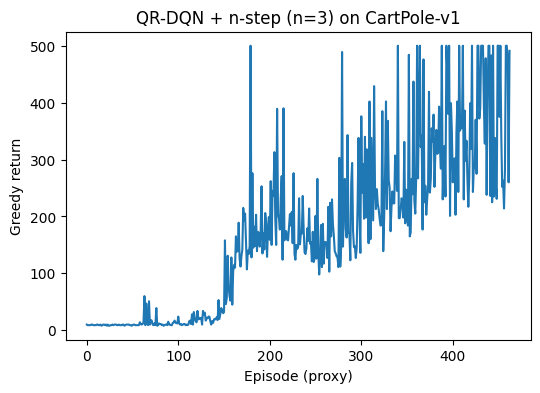

In [ ]:
@torch.no_grad()
def evaluate(env, episodes=10):
    scores = []
    for ep in range(episodes):
        s, _ = env.reset(seed=cfg.seed + 1000 + ep)
        total = 0.0
        for _ in range(1000):
            a = act_epsilon_greedy(s, 0.0)
            s, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc: break
        scores.append(total)
    return float(np.mean(scores)), scores

mean_eval, eval_scores = evaluate(env, episodes=10)
print("Mean greedy return over 10 episodes:", mean_eval)

import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
plt.plot(returns)
plt.xlabel("Episode (proxy)")
plt.ylabel("Greedy return")
plt.title("QR-DQN + n-step (n=3) on CartPole-v1")
plt.show()


Save checkpoint

In [ ]:
save_path = "/content/qrdqn_nstep3_cartpole.pt"
torch.save(online.state_dict(), save_path)
print("Saved:", save_path)


Saved: /content/qrdqn_nstep3_cartpole.pt


# **COMPARE**

In [ ]:
# %pip -q install gymnasium==0.29.1

import random, collections
import numpy as np
import torch
import torch.nn as nn

try:
    import gymnasium as gym
except Exception:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "gymnasium==0.29.1"])
    import gymnasium as gym

def set_seed(seed: int):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)


In [ ]:
class Cfg:
    env_id         = "CartPole-v1"
    base_seed      = 7
    device         = "cuda" if torch.cuda.is_available() else "cpu"

    # QR-DQN core
    n_quantiles    = 51
    gamma          = 0.99

    # Net / Optim
    hidden         = 128
    lr             = 5e-4
    adam_eps       = 1e-8
    grad_clip      = 10.0

    # Replay & Train
    buffer_size    = 100_000
    batch_size     = 64
    learn_start    = 1_000
    total_steps    = 50_000
    target_tau     = 1_000   # hard update every τ steps

    # Exploration
    eps_start      = 1.0
    eps_final      = 0.01
    eps_decay      = 25_000

cfg = Cfg()
device = torch.device(cfg.device)
device


device(type='cuda')

In [ ]:
def make_env(env_id, seed):
    env = gym.make(env_id)
    env.reset(seed=seed)
    return env

_tmp = make_env(cfg.env_id, cfg.base_seed)
obs_dim = _tmp.observation_space.shape[0]
n_actions = _tmp.action_space.n
_tmp.close()
obs_dim, n_actions


(4, np.int64(2))

QR-DQN network ([B, A, N])

In [ ]:
class QRDQN(nn.Module):
    def __init__(self, obs_dim, n_actions, n_quantiles, hidden=128):
        super().__init__()
        self.n_actions = n_actions
        self.n_quantiles = n_quantiles
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden), nn.ReLU(),
            nn.Linear(hidden, hidden), nn.ReLU(),
            nn.Linear(hidden, n_actions * n_quantiles),
        )
    def forward(self, x):
        out = self.net(x)
        return out.view(x.size(0), self.n_actions, self.n_quantiles)


Replay buffer + n-step collector

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.data = collections.deque(maxlen=capacity)
    def push(self, s, a, Rn, ns, dn):
        self.data.append((s, a, Rn, ns, dn))
    def sample(self, B, device):
        idx = np.random.randint(0, len(self.data), size=B)
        s, a, Rn, ns, dn = zip(*(self.data[i] for i in idx))
        return (
            torch.tensor(np.array(s),  dtype=torch.float32, device=device),
            torch.tensor(np.array(a),  dtype=torch.int64,   device=device),
            torch.tensor(np.array(Rn), dtype=torch.float32, device=device),
            torch.tensor(np.array(ns), dtype=torch.float32, device=device),
            torch.tensor(np.array(dn), dtype=torch.float32, device=device),
        )
    def __len__(self): return len(self.data)

class NStepCollector:
    """Turn a 1-step stream into n-step tuples (s_t, a_t, R_t^n, s_{t+n}, done^n)."""
    def __init__(self, n, gamma):
        self.n = n
        self.gamma = gamma
        self.buf = collections.deque()
    def reset(self):
        self.buf.clear()
    def push(self, s, a, r, done):
        self.buf.append((s, a, r, done))
        if len(self.buf) < self.n and not done:
            return None
        Rn = 0.0
        discount = 1.0
        last = 0
        for i, (_, _, r_i, d_i) in enumerate(self.buf):
            Rn += discount * r_i
            last = i
            if d_i:
                break
            discount *= self.gamma
            if i+1 == self.n:
                break
        s0, a0, _, _ = self.buf[0]
        dn = float(self.buf[last][3])
        return s0, a0, Rn, last, dn
    def pop_left(self):
        if self.buf: self.buf.popleft()


Quantile midpoints + pinball loss (κ=0)

In [ ]:
def quantile_midpoints(N, device):
    return (torch.arange(N, device=device, dtype=torch.float32) + 0.5) / N

def pinball_loss(pred_q, target_q, taus):
    """
    pred_q:   [B, N]
    target_q: [B, N]
    taus:     [N]
    """
    B, N = pred_q.shape
    u = target_q.unsqueeze(1) - pred_q.unsqueeze(2)  # [B, N, N]
    abs_u = u.abs()
    taus = taus.view(1, N, 1)
    indicator = (u.detach() < 0).float()
    loss = (taus - indicator).abs() * abs_u
    return loss.mean()


Training utilities (supports n_step=1 or 3)

In [ ]:
def epsilon_by_step(step, cfg):
    return float(cfg.eps_final + (cfg.eps_start - cfg.eps_final) * max(0.0, 1.0 - step / cfg.eps_decay))

@torch.no_grad()
def act_epsilon_greedy(state, online, epsilon, device):
    if random.random() < epsilon:
        return random.randrange(online.n_actions)
    s = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    q = online(s)
    return int(q.mean(2).argmax(1).item())

def compute_loss(batch, online, target, taus, cfg, gamma_n):
    s, a, Rn, ns, dn = batch
    B = s.size(0)

    q_all = online(s)
    q_chosen = q_all.gather(1, a.view(B,1,1).expand(B,1,cfg.n_quantiles)).squeeze(1)

    with torch.no_grad():
        next_q_online = online(ns)
        next_a = next_q_online.mean(2).argmax(1, keepdim=True)
        next_q_target = target(ns).gather(1, next_a.unsqueeze(-1).expand(-1,-1,cfg.n_quantiles)).squeeze(1)
        target_q = Rn.unsqueeze(1) + (1.0 - dn.unsqueeze(1)) * gamma_n * next_q_target

    return pinball_loss(q_chosen, target_q, taus)

def train_one(run_name: str, n_step: int, seed: int, cfg=cfg):
    print(f"=== Training {run_name} | n_step={n_step} ===")
    set_seed(seed)
    env = make_env(cfg.env_id, seed)
    replay = ReplayBuffer(cfg.buffer_size)

    online = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
    target = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
    target.load_state_dict(online.state_dict())

    optimizer = torch.optim.Adam(online.parameters(), lr=cfg.lr, eps=cfg.adam_eps)
    taus = quantile_midpoints(cfg.n_quantiles, device=device)
    gamma_n = cfg.gamma ** n_step

    collector = NStepCollector(n_step, cfg.gamma) if n_step > 1 else None

    returns = []
    s, _ = env.reset(seed=seed)

    for step in range(1, cfg.total_steps + 1):
        eps = epsilon_by_step(step, cfg)
        a = act_epsilon_greedy(s, online, eps, device)
        ns, r, term, trunc, _ = env.step(a)
        done = term or trunc

        if n_step == 1:
            replay.push(s, a, r, ns, float(done))
        else:
            pack = collector.push(s, a, r, done)
            if pack is not None:
                s0, a0, Rn, last, dn = pack
                replay.push(s0, a0, Rn, ns, dn)
                collector.pop_left()

        s = ns

        if len(replay) >= cfg.learn_start:
            batch = replay.sample(cfg.batch_size, device)
            loss = compute_loss(batch, online, target, taus, cfg, gamma_n)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            if cfg.grad_clip is not None:
                nn.utils.clip_grad_norm_(online.parameters(), cfg.grad_clip)
            optimizer.step()

        if step % cfg.target_tau == 0:
            target.load_state_dict(online.state_dict())

        if done:
            with torch.no_grad():
                gret = 0.0
                s_eval, _ = env.reset()
                for _ in range(500):
                    ae = act_epsilon_greedy(s_eval, online, 0.0, device)
                    s_eval, r_eval, te, tr, _ = env.step(ae)
                    gret += r_eval
                    if te or tr: break
            returns.append(gret)
            s, _ = env.reset()
            if collector: collector.reset()

        if step % 5000 == 0:
            last = np.mean(returns[-10:]) if returns else 0.0
            print(f"[{run_name}] step {step:6d} | buffer={len(replay):6d} | eps={eps:.3f} | recent(10)={last:.1f}")

    # Final greedy eval (10 eps)
    @torch.no_grad()
    def evaluate(episodes=10):
        scores = []
        for ep in range(episodes):
            s_eval, _ = env.reset(seed=seed + 1000 + ep)
            total = 0.0
            for _ in range(1000):
                ae = act_epsilon_greedy(s_eval, online, 0.0, device)
                s_eval, r_eval, te, tr, _ = env.step(ae)
                total += r_eval
                if te or tr: break
            scores.append(total)
        return float(np.mean(scores))

    mean_eval = evaluate(10)
    env.close()

    ckpt = f"/content/{run_name}.pt"
    torch.save(online.state_dict(), ckpt)
    print(f"Saved: {ckpt} | Mean greedy eval (10 eps): {mean_eval:.2f}")

    return {"name": run_name, "mean_eval": mean_eval, "ckpt": ckpt}


Multi-seed experiment (Baseline vs New agent)

In [ ]:
def run_experiment(tag, n_step, seeds, cfg_template):
    res = []
    for s in seeds:
        cfg_local = copy.deepcopy(cfg_template)
        out = train_one(run_name=f"{tag}_seed{s}", n_step=n_step, seed=s, cfg=cfg_local)
        res.append(out["mean_eval"])
    return np.array(res, dtype=np.float32)

In [ ]:
import numpy as np, copy

def run_experiment(tag, n_step, seeds, cfg_template):
    res = []
    for s in seeds:
        cfg_local = copy.deepcopy(cfg_template)
        out = train_one(run_name=f"{tag}_seed{s}", n_step=n_step, seed=s, cfg=cfg_local)
        res.append(out["mean_eval"])
    return np.array(res, dtype=np.float32)

def summarize(name, scores):
    print(f"{name}: mean={scores.mean():.2f}  median={np.median(scores):.2f}  std={scores.std(ddof=1):.2f}  n={len(scores)}  scores={scores.round(1)}")

seeds = [7, 8, 9, 10, 11]

print("=== Multi-seed (current config) ===")
base_scores = run_experiment("baseline_1step", n_step=1, seeds=seeds, cfg_template=cfg)
nstep_scores = run_experiment("nstep3", n_step=3, seeds=seeds, cfg_template=cfg)

summarize("Baseline (1-step, κ=0)", base_scores)
summarize("New agent (n=3, κ=0)",  nstep_scores)


=== Multi-seed (current config) ===
=== Training baseline_1step_seed7 | n_step=1 ===
[baseline_1step_seed7] step   5000 | buffer=  5000 | eps=0.802 | recent(10)=212.8
[baseline_1step_seed7] step  10000 | buffer= 10000 | eps=0.604 | recent(10)=275.1
[baseline_1step_seed7] step  15000 | buffer= 15000 | eps=0.406 | recent(10)=122.6
[baseline_1step_seed7] step  20000 | buffer= 20000 | eps=0.208 | recent(10)=138.6
[baseline_1step_seed7] step  25000 | buffer= 25000 | eps=0.010 | recent(10)=120.5
[baseline_1step_seed7] step  30000 | buffer= 30000 | eps=0.010 | recent(10)=134.7
[baseline_1step_seed7] step  35000 | buffer= 35000 | eps=0.010 | recent(10)=152.9
[baseline_1step_seed7] step  40000 | buffer= 40000 | eps=0.010 | recent(10)=167.5
[baseline_1step_seed7] step  45000 | buffer= 45000 | eps=0.010 | recent(10)=158.7
[baseline_1step_seed7] step  50000 | buffer= 50000 | eps=0.010 | recent(10)=146.2
Saved: /content/baseline_1step_seed7.pt | Mean greedy eval (10 eps): 269.80
=== Training baseli

Evaluate any saved checkpoint (more episodes)

In [ ]:
@torch.no_grad()
def load_and_eval(ckpt_path, episodes=30):
    env = make_env(cfg.env_id, cfg.base_seed + 2025)
    model = QRDQN(obs_dim, n_actions, cfg.n_quantiles, cfg.hidden).to(device)
    state_dict = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state_dict)

    def greedy_episode(seed=None):
        s, _ = env.reset(seed=seed)
        total = 0.0
        for _ in range(1000):
            a = act_epsilon_greedy(s, model, 0.0, device)
            s, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc: break
        return total

    scores = [greedy_episode(cfg.base_seed + 3000 + i) for i in range(episodes)]
    env.close()
    return float(np.mean(scores)), scores

m1, _ = load_and_eval("/content/baseline_1step_seed7.pt", episodes=100)
m2, _ = load_and_eval("/content/nstep3_seed7.pt", episodes=100)
print("Re-eval baseline:", m1, " | Re-eval nstep3:", m2)


Re-eval baseline: 270.47  | Re-eval nstep3: 395.31


Plot curves or export CSV

In [ ]:
import pandas as pd
from google.colab import files

df = pd.DataFrame({
    "seed": seeds,
    "baseline_1step": base_scores,
    "nstep3": nstep_scores
})
df["diff_n3_minus_base"] = df["nstep3"] - df["baseline_1step"]
df
df.to_csv("/content/qrddqn_nstep_vs_baseline.csv", index=False)
files.download("/content/qrddqn_nstep_vs_baseline.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Re-evaluate both sets over 300 episodes each (greedy)

In [ ]:
# CartPole (Gymnasium) and MinAtar wrappers with a uniform API
import numpy as np
import gymnasium as gym

class GymCartPoleLike:
    def __init__(self, seed=0):
        self.env = gym.make("CartPole-v1")
        self.env.reset(seed=seed)
        self.action_space = type("A", (), {"n": self.env.action_space.n})
        self.shape = (self.env.observation_space.shape[0],)  # (4,)
    def reset(self, seed=None):
        obs, info = self.env.reset(seed=seed)
        return obs.astype(np.float32), info
    def step(self, a):
        obs, r, term, trunc, info = self.env.step(a)
        return obs.astype(np.float32), float(r), bool(term), bool(trunc), info
    def close(self): self.env.close()

def make_env_any(env_kind, seed=0, game="breakout", sticky=0.1):
    if env_kind.lower() == "cartpole":
        return GymCartPoleLike(seed)
    elif env_kind.lower() == "minatar":
        return make_minatar_env(seed=seed, game=game, sticky=sticky)
    else:
        raise ValueError(f"Unknown env_kind={env_kind} (use 'cartpole' or 'minatar')")


In [ ]:
import torch, torch.nn as nn
import numpy as np

class QRDQN_MLP_Dyn(nn.Module):
    def __init__(self, obs_dim, n_actions, n_quantiles, h1, h2):
        super().__init__()
        self.n_actions = n_actions
        self.n_quantiles = n_quantiles
        self.net = nn.Sequential(
            nn.Linear(obs_dim, h1), nn.ReLU(inplace=True),
            nn.Linear(h1, h2),      nn.ReLU(inplace=True),
            nn.Linear(h2, n_actions * n_quantiles),
        )
    def forward(self, x):
        z = self.net(x)
        return z.view(x.size(0), self.n_actions, self.n_quantiles)

def _unwrap_state_dict(sd):
    if isinstance(sd, dict) and "model" in sd and isinstance(sd["model"], dict):
        return sd["model"]
    return sd

def _build_model_for_state(state, obs_shape, n_actions, n_quantiles):
    keys = list(state.keys())
    has_conv = any(k.startswith("torso.") for k in keys)
    has_net  = any(k.startswith("net.")   for k in keys)

    if len(obs_shape) == 1:
        obs_dim = obs_shape[0]
        if has_net:
            h1 = state["net.0.weight"].shape[0]
            h2 = state["net.2.weight"].shape[0]
            out = state["net.4.weight"].shape[0]
            if out != n_actions * n_quantiles and out % n_actions == 0:
                n_quantiles = out // n_actions
            model = QRDQN_MLP_Dyn(obs_dim, n_actions, n_quantiles, h1, h2).to(device)
            arch  = "mlp"
            def prep(s_np):
                return torch.tensor(s_np, dtype=torch.float32, device=device).unsqueeze(0)
            return model, arch, prep
        else:
            raise RuntimeError("Checkpoint has no 'net.*' keys but obs is 1D: not an MLP QR-DQN checkpoint?")
    else:
        C,H,W = obs_shape
        if has_conv:
            has_duel = any(k.startswith(("adv.","val.")) for k in keys)
            has_noisy= any("noisy" in k for k in keys)
            if has_duel or has_noisy:
                model = QRDQNConv_DuelingNoisy(C, n_actions, n_quantiles, hidden=128, sigma0=0.5, use_noisy=has_noisy).to(device)
                arch  = "conv_duel_noisy" if has_noisy else "conv_duel"
            else:
                model = QRDQNConv(C, n_actions, n_quantiles, hidden=128).to(device)
                arch  = "conv"
            def prep(s_np):
                return torch.tensor(s_np, dtype=torch.float32, device=device).unsqueeze(0)
            return model, arch, prep
        else:
            raise RuntimeError("Checkpoint has no 'torso.*' keys but obs is image-like: not a Conv QR-DQN checkpoint?")

@torch.no_grad()
def eval_checkpoint_anyenv(
    ckpt_path, env_kind, episodes=300, seed_base=54321, game="breakout", sticky=0.1, n_quantiles=51
):
    env = make_env_any(env_kind, seed=seed_base, game=game, sticky=sticky)
    obs0, _ = env.reset()
    nA = env.action_space.n
    obs_shape = obs0.shape

    raw = torch.load(ckpt_path, map_location="cpu")
    state = _unwrap_state_dict(raw)

    model, arch, prep = _build_model_for_state(state, obs_shape, nA, n_quantiles)
    model.load_state_dict(state)

    def greedy_ep(ep_idx):
        s, _ = env.reset(seed=seed_base + ep_idx)
        total = 0.0
        for _ in range(5000):
            s_t = prep(s)
            q = model(s_t)
            a = int(q.mean(2).argmax(1).item())
            s, r, term, trunc, _ = env.step(a)
            total += r
            if term or trunc: break
        return float(total)

    scores = [greedy_ep(i) for i in range(episodes)]
    env.close()
    arr = np.array(scores, dtype=np.float32)
    return float(arr.mean()), float(arr.std(ddof=1)), scores


In [ ]:
pairs = [
    ("/content/baseline_1step_seed7.pt", "/content/nstep3_seed7.pt"),
    ("/content/baseline_1step_seed8.pt", "/content/nstep3_seed8.pt"),
    ("/content/baseline_1step_seed10.pt","/content/nstep3_seed10.pt"),
    ("/content/baseline_1step_seed11.pt","/content/nstep3_seed11.pt"),
]

rows = []
for seed, (b_ckpt, n_ckpt) in zip([7,8,9,10,11], pairs):
    mb, sb, _ = eval_checkpoint_anyenv(b_ckpt, env_kind="cartpole", episodes=1000, seed_base=54321)
    mn, sn, _ = eval_checkpoint_anyenv(n_ckpt, env_kind="cartpole", episodes=1000, seed_base=54321)
    rows.append((seed, mb, sb, mn, sn, mn - mb))

print("seed | 1-step mean±sd  | n=3 mean±sd   | Δ (n3 - 1step)")
for seed, mb, sb, mn, sn, d in rows:
    print(f"{seed:>4} | {mb:6.2f}±{sb:5.2f} | {mn:6.2f}±{sn:5.2f} | {d:+.2f}")

import numpy as np
deltas = np.array([r[-1] for r in rows], dtype=np.float32)
print("\nΔ summary: mean={:.2f}, median={:.2f}, std={:.2f}, n={}".format(
    deltas.mean(), np.median(deltas), deltas.std(ddof=1), len(deltas)
))


seed | 1-step mean±sd  | n=3 mean±sd   | Δ (n3 - 1step)
   7 | 274.56±103.00 | 389.80±102.69 | +115.24
   8 | 185.57±14.33 | 387.16±93.93 | +201.60
   9 | 113.23± 5.31 | 418.70±93.68 | +305.46
  10 | 150.66± 3.97 | 386.92±112.43 | +236.25

Δ summary: mean=214.64, median=218.93, std=79.09, n=4
